In [2]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
class ODEFunc(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 2)
        )
    def forward(self, t, y):
        return self.net(y)


In [4]:
df = pd.read_csv("1976-2020-senate.csv")

In [6]:
df
df_mod = df[df['stage'] == 'gen']
df_mod = df_mod[df_mod['party_simplified'].isin(['REPUBLICAN', 'DEMOCRAT'])]
grouped = df_mod.groupby(['year', 'party_simplified'])['candidatevotes'].sum().unstack().fillna(0)
grouped['Total'] = grouped.sum(axis=1)
grouped['DEMOCRAT_pct'] = 100 * grouped['DEMOCRAT'] / grouped['Total']
grouped['REPUBLICAN_pct'] = 100 * grouped['REPUBLICAN'] / grouped['Total']
vote_df = grouped[['DEMOCRAT_pct', 'REPUBLICAN_pct']]


In [7]:
y0 = torch.tensor([vote_df.iloc[0].values], dtype=torch.float32)
t = torch.linspace(0, len(vote_df)-1, len(vote_df))
y_data = torch.tensor(vote_df.values, dtype=torch.float32)

C:\Users\alanr\AppData\Local\Temp\ipykernel_22208\2638541814.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  y0 = torch.tensor([vote_df.iloc[0].values], dtype=torch.float32)


In [8]:
func = ODEFunc()
optimizer = torch.optim.Adam(func.parameters(), lr=0.01)

In [9]:
for epoch in range(1000):
    pred_y = odeint(func, y0[0], t)
    loss = torch.mean((pred_y - y_data)**2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 42.6767
Epoch 100, Loss: 11.3883
Epoch 200, Loss: 11.3264
Epoch 300, Loss: 11.2805
Epoch 400, Loss: 11.2297
Epoch 500, Loss: 11.1667
Epoch 600, Loss: 11.1359
Epoch 700, Loss: 11.1055
Epoch 800, Loss: 11.0862
Epoch 900, Loss: 11.0696


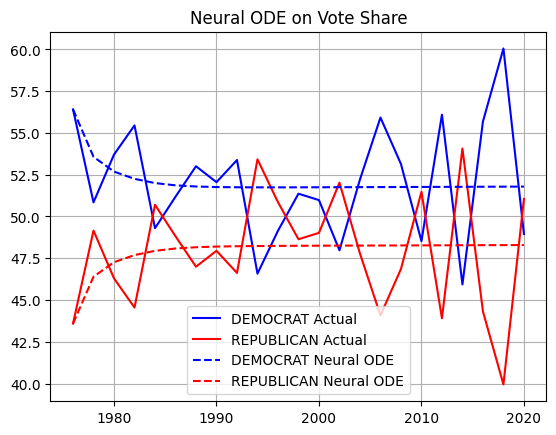

In [10]:
pred = pred_y.detach().numpy()
plt.plot(vote_df.index, vote_df['DEMOCRAT_pct'], 'b', label='DEMOCRAT Actual')
plt.plot(vote_df.index, vote_df['REPUBLICAN_pct'], 'r', label='REPUBLICAN Actual')
plt.plot(vote_df.index, pred[:,0], 'b--', label='DEMOCRAT Neural ODE')
plt.plot(vote_df.index, pred[:,1], 'r--', label='REPUBLICAN Neural ODE')
plt.title("Neural ODE on Vote Share")
plt.legend()
plt.grid(True)
plt.show()